In [21]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset
import torch
import soundfile as sf
import numpy as np
import librosa
from IPython.display import Audio

from datasets import load_dataset
from pdfminer.high_level import extract_text

In [8]:
# DO: Longer and better input data
# DO: Multiple input data

In [9]:
# Extract text from pdf
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)

text = extract_text_from_pdf(pdf_path="inputs/cognita_test_lite.pdf")
print("Text extraction completed.")
#print(text)

Text extraction completed.


In [10]:
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

inputs = processor(text=text, return_tensors="pt")

In [11]:
# TOGGLE 1: LOAD ARCTIC DATASET EMBEDDINGS FOR SPEAKER CHARACTERISTICS

"""# load xvector containing speaker's voice characteristics from a dataset
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[10]["xvector"]).unsqueeze(0)
print(speaker_embeddings.shape)"""

'# load xvector containing speaker\'s voice characteristics from a dataset\nembeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")\nspeaker_embeddings = torch.tensor(embeddings_dataset[10]["xvector"]).unsqueeze(0)\nprint(speaker_embeddings.shape)'

In [12]:
# TOGGLE 2: EXTRACT VOICE CHARACTERISTICS FROM  LOCAL AUDIO FILE
def extract_voice_characteristics(audio_file, output_file, sr=22050, embedding_dim=512):

    y, sr = librosa.load(audio_file, sr=sr)

    # Assuming you have a method to extract a 512-dimensional embedding from the audio
    # Replace this with your actual method to get the 512-dimensional embedding
    embedding = extract_embedding(y, sr, embedding_dim)

    # Convert the embedding to a torch tensor of size [1, 512]
    embedding_tensor = torch.tensor(embedding).unsqueeze(0)

    # Save the embedding tensor to a .npy file
    np.save(output_file, embedding_tensor.numpy())

def extract_embedding(y, sr, embedding_dim):
    """
    Placeholder function to extract a 512-dimensional embedding from audio data.
    Replace this with your actual method to get the desired embedding.

    Parameters:
    y (np.ndarray): Audio signal.
    sr (int): Sample rate.
    embedding_dim (int): Dimensionality of the embedding to extract.

    Returns:
    np.ndarray: A 512-dimensional embedding.
    """
    # Example: Compute MFCCs and flatten to 512 dimensions
    n_mfcc = 13  # Example number of MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    embedding = mfccs.flatten()[:embedding_dim]  # Example flattening to 512 dimensions

    return embedding

In [ ]:
# TOGGLE 2: EXTRACT voice characteristics from the given recording file

audio_file = 'inputs/Rec1.wav'
output_file = 'Voice_npy/voice_characteristics_4.npy'
extract_voice_characteristics(audio_file, output_file)

In [16]:
#Load local voice characteristics from the .npy file
local_embeddings = np.load('Voice_npy/AvgVC.npy')

# Convert the numpy array to a PyTorch tensor
speaker_embeddings = torch.tensor(local_embeddings)

# Example to use with the rest of your code
print(speaker_embeddings.shape)

torch.Size([1, 512])


In [ ]:
# TOGGLE MultiSample Visualization 
"""import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_embedding(embedding_file, method='tsne', perplexity=5):
    """
    Visualizes the voice embedding using t-SNE or PCA.

    Parameters:
    embedding_file (str): Path to the .npy file containing the embedding.
    method (str): Method for dimensionality reduction ('tsne' or 'pca'). Default is 'tsne'.
    perplexity (int): Perplexity parameter for t-SNE. Default is 5.
    """
    # Load the embedding
    embedding = np.load(embedding_file)
    
    if embedding.shape[0] < 2:
        raise ValueError("Need at least 2 samples to visualize embeddings")

    if method == 'tsne':
        # Use t-SNE to reduce the embedding to 2D
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        embedding_2d = tsne.fit_transform(embedding)
    elif method == 'pca':
        # Use PCA to reduce the embedding to 2D
        pca = PCA(n_components=2)
        embedding_2d = pca.fit_transform(embedding)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    # Plot the 2D embedding
    plt.figure(figsize=(8, 8))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c='blue', marker='o')
    plt.title(f'{method.upper()} Visualization of Voice Embedding')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize the embedding
visualize_embedding('Voice_npy/AvgVC.npy', method='tsne', perplexity=5)"""


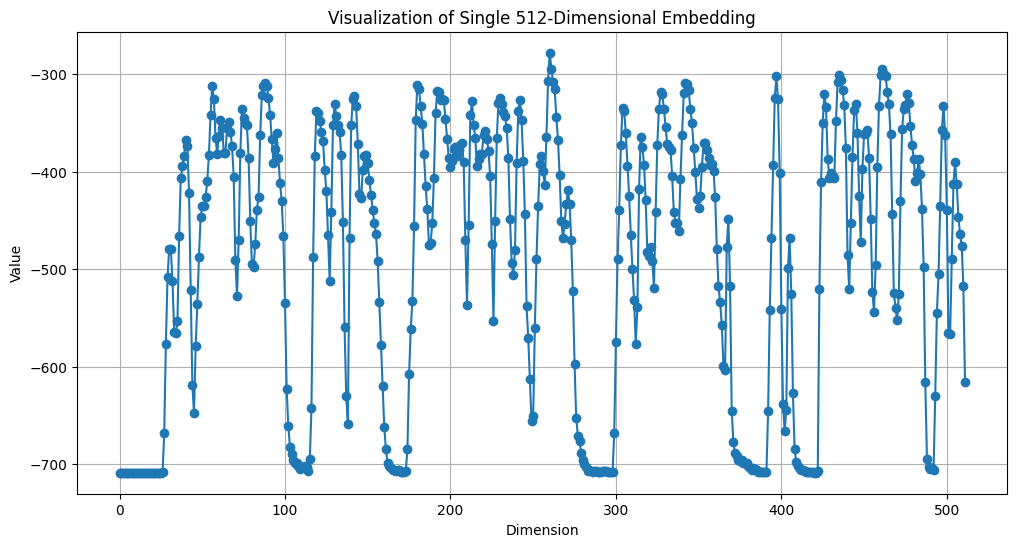

In [17]:
# TOGGLE Single Sample Visualization 

import numpy as np
import matplotlib.pyplot as plt

def visualize_single_embedding(embedding_file):
    """
    Visualizes a single 512-dimensional embedding by plotting its values.

    Parameters:
    embedding_file (str): Path to the .npy file containing the embedding.
    """
    # Load the embedding
    embedding = np.load(embedding_file)

    # Ensure it's a 1D array of length 512
    if embedding.shape[1] != 512:
        raise ValueError("Embedding should have 512 dimensions")

    # Plot the embedding values
    plt.figure(figsize=(12, 6))
    plt.plot(embedding[0], marker='o')
    plt.title('Visualization of Single 512-Dimensional Embedding')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Visualize the single embedding
visualize_single_embedding('Voice_npy/voice_characteristics.npy')


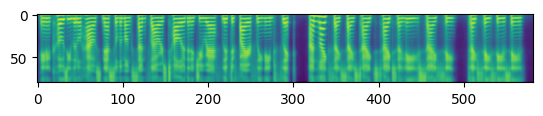

In [19]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [22]:
#Generate speech from the text using the speaker characteristics
with torch.no_grad():
    speech = vocoder(spectrogram)

Audio(speech.numpy(), rate=16000)
sf.write("outputs/speechFromTTSOnly8.wav", speech.numpy(), samplerate=16000)